# DEV

In [1]:
%load_ext autoreload
%autoreload 2

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imen-mahdi. Use `wandb login --relogin` to force relogin


/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(


total number of samples: 95, train samples: 66, Validation: 29
Loading Images for centre:  0
Loading Labels for centre:  0


100%|██████████| 66/66 [00:00<00:00, 73.29File/s]


Loading Images for centre:  1
Loading Labels for centre:  1


100%|██████████| 29/29 [00:00<00:00, 75.02File/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10: 100%|██████████| 195/195 [00:06<00:00, 28.30it/s, v_num=if0b, val_loss=0.0591, train_loss=0.0395]
Loading Images for centre:  0
Loading Labels for centre:  0


100%|██████████| 66/66 [00:00<00:00, 66.90File/s]


Loading Images for centre:  1
Loading Labels for centre:  1


100%|██████████| 29/29 [00:00<00:00, 68.00File/s]


Loading Images for centre:  2
Loading Labels for centre:  2


100%|██████████| 74/74 [00:01<00:00, 60.21File/s]


Loading Images for centre:  3
Loading Labels for centre:  3


100%|██████████| 51/51 [00:00<00:00, 68.30File/s]


Loading Images for centre:  4
Loading Labels for centre:  4


100%|██████████| 47/47 [00:00<00:00, 60.92File/s]


Loading Images for centre:  5
Loading Labels for centre:  5


100%|██████████| 50/50 [00:01<00:00, 44.49File/s]
Restoring states from the checkpoint path at ./M-M/068sif0b/checkpoints/epoch=10-step=2145.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./M-M/068sif0b/checkpoints/epoch=10-step=2145.ckpt


Testing DataLoader 5: 100%|██████████| 50/50 [00:03<00:00, 14.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03938731258060311    │    0.05907154347426737    │    0.07059815582702761    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃       DataLoader 4        ┃       DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05236804174457443    │    0.06769312220450134    │    0.09842617480538117    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), e

epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
test_loss/dataloader_idx_0,▁
test_loss/dataloader_idx_1,▁
test_loss/dataloader_idx_2,▁
test_loss/dataloader_idx_3,▁
test_loss/dataloader_idx_4,▁
test_loss/dataloader_idx_5,▁
train_loss,█▃▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▇▇▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁▁
epoch,11


        Dice_BG_ED  Dice_LV_ED  Dice_MYO_ED  Dice_RV_ED  Dice_BG_ES  \
Centre                                                                
0         0.993290    0.940612     0.849978    0.930427    0.986684   
1         0.990437    0.930794     0.820563    0.883255    0.981092   
2         0.989421    0.932393     0.811372    0.886268    0.979106   
3         0.991206    0.941486     0.807861    0.900284    0.982585   
4         0.989054    0.902708     0.762772    0.805422    0.978410   
5         0.984946    0.905221     0.738920    0.845856    0.970413   

        Dice_LV_ES  Dice_MYO_ES  Dice_RV_ES  IoU_BG_ED  IoU_LV_ED  IoU_MYO_ED  \
Centre                                                                          
0         0.890891     0.740513    0.870616   0.994402   0.898021    0.829610   
1         0.872118     0.698550    0.796389   0.991008   0.846745    0.787373   
2         0.874937     0.686152    0.799807   0.988672   0.806505    0.734765   
3         0.890629     0.6

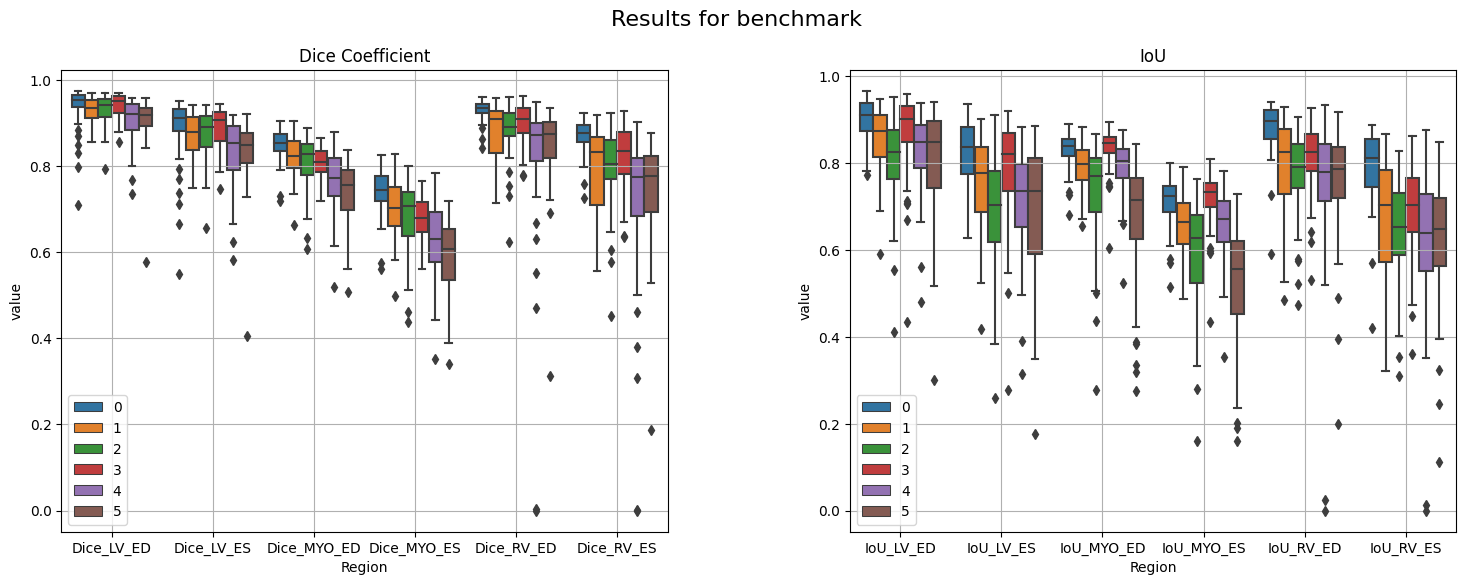

In [2]:
from scripts.pipeline import pipeline
pipeline()

# Test

In [2]:
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn.functional as F


from monai.transforms import ScaleIntensity
from monai.config import print_config

from scripts.train import LitUnet
from scripts.data import CentreDataModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import seed_everything

%load_ext autoreload
%autoreload 2

from scripts.utils import *

#print_config()


/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import wandb
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="M-M", entity="imen-mahdi")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imen-mahdi. Use `wandb login --relogin` to force relogin


In [4]:
seed_everything(42, workers=True)

model = LitUnet(lr=1e-3)

Global seed set to 42


In [5]:
transform =  ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)
dm = CentreDataModule("A", split_ratio=0.7, load_transform=transform, batch_size=8)

In [5]:
# # Training and Validation
# trainer = pl.Trainer(max_epochs=50, 
#                      deterministic=True, 
#                      logger=wandb_logger,
#                      log_every_n_steps=1, 
#                      enable_model_summary=False,
#                      callbacks=[EarlyStopping('val_loss', patience=2)], 
#                      fast_dev_run=False)
# trainer.fit(model, datamodule=dm)
# trainer.save_checkpoint("checkpoints/benchmark_deterministic.ckpt")

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(


total number of samples: 95, train samples: 66, Validation: 29
Loading Images for centre:  0
Loading Labels for centre:  0


100%|██████████| 66/66 [00:01<00:00, 57.97File/s]


Loading Images for centre:  1
Loading Labels for centre:  1


100%|██████████| 29/29 [00:00<00:00, 59.47File/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10: 100%|██████████| 195/195 [00:06<00:00, 29.13it/s, v_num=do61, val_loss=0.0591, train_loss=0.0395]


In [19]:
# Test
trainer = pl.Trainer(logger=wandb_logger)
trainer.test(model, ckpt_path="checkpoints/benchmark_deterministic.ckpt", datamodule=dm)

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at checkpoints/benchmark_deterministic.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at checkpoints/benchmark_deterministic.ckpt


Testing DataLoader 4: 100%|██████████| 50/50 [00:03<00:00, 15.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04522495067565002    │    0.07059815582702761    │    0.05236804174457443    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃       DataLoader 4        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06769312220450134    │    0.09842617480538117    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test_loss/dataloader_idx_0': 0.04522495067565002},
 {'test_loss/dataloader_idx_1': 0.07059815582702761},
 {'test_loss/dataloader_idx_2': 0.05236804174457443},
 {'test_loss/dataloader_idx_3': 0.06769312220450134},
 {'test_loss/dataloader_idx_4': 0.09842617480538117}]

wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.


In [26]:
results = trainer.model.results

In [27]:
results[["Centre", "batch_idx"]] = results.iloc[:, :2].astype(int)

In [26]:
metadata = trainer.datamodule.metadata
# order resukts by centre and subjectid
metadata = metadata.sort_values(by=["Centre", "SubjectID"])
metadata

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight,Image_path,Seg_path,time_dim,x_dim,y_dim,z_dim,x_pixdim,y_pixdim,z_pixdim
SubjectID,,,,,,,,,,,,,,,,,,,
A1D9Z7,Siemens,A,0,22,11,53,HCM,M,175.0,75.0,Data_original/OpenDataset/Training/Labeled/A1D...,Data_original/OpenDataset/Training/Labeled/A1D...,25,208,256,13,1.250000,1.250000,8.8
A2C0I1,Siemens,A,0,0,7,61,HCM,M,172.0,89.0,Data_original/OpenDataset/Training/Labeled/A2C...,Data_original/OpenDataset/Training/Labeled/A2C...,25,208,256,12,1.250000,1.250000,8.0
A2L1N6,Siemens,A,0,0,12,31,DCM,M,168.0,91.0,Data_original/OpenDataset/Testing/A2L1N6/A2L1N...,Data_original/OpenDataset/Testing/A2L1N6/A2L1N...,25,196,240,13,1.416667,1.416667,9.6
A4B5U4,Siemens,A,0,0,10,54,DCM,F,160.0,45.0,Data_original/OpenDataset/Training/Labeled/A4B...,Data_original/OpenDataset/Training/Labeled/A4B...,25,196,240,14,1.012500,1.012500,9.6
A4J4S4,Siemens,A,0,0,7,30,HCM,M,169.0,70.0,Data_original/OpenDataset/Training/Labeled/A4J...,Data_original/OpenDataset/Training/Labeled/A4J...,25,208,256,11,1.250000,1.250000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O7Q7U3,Canon,D,5,29,11,72,HCM,F,148.0,64.0,Data_original/OpenDataset/Validation/O7Q7U3/O7...,Data_original/OpenDataset/Validation/O7Q7U3/O7...,30,512,440,12,0.795500,0.795500,10.0
P8V0Y7,Canon,D,5,27,9,73,HCM,M,164.0,64.0,Data_original/OpenDataset/Validation/P8V0Y7/P8...,Data_original/OpenDataset/Validation/P8V0Y7/P8...,28,512,440,14,0.795500,0.795500,10.0
Q4W5Z8,Canon,D,5,33,10,54,NOR,M,191.0,85.0,Data_original/OpenDataset/Testing/Q4W5Z8/Q4W5Z...,Data_original/OpenDataset/Testing/Q4W5Z8/Q4W5Z...,34,512,440,14,0.795500,0.795500,10.0
